In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D ,Dropout,Flatten,Dense,Input 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array , load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
print("[INFO] loading images...")
data = []
labels = []
imagePaths = list(paths.list_images('dataset'))

[INFO] loading images...


In [6]:
# loop over the image paths
for imagePath in imagePaths:
# extract the class label from the filename
    #label = imagePath.split('\\')[1] or
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\asgha\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
# (trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [9]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
input_tensor = Input(shape=(224, 224, 3))
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor = input_tensor)
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [12]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
113/113 [==============================] - 417s 3s/step - loss: 0.4905 - accuracy: 0.7915 - val_loss: 0.1261 - val_accuracy: 0.9780
Epoch 2/20
113/113 [==============================] - 283s 3s/step - loss: 0.1443 - accuracy: 0.9641 - val_loss: 0.0697 - val_accuracy: 0.9868
Epoch 3/20
113/113 [==============================] - 333s 3s/step - loss: 0.0787 - accuracy: 0.9835 - val_loss: 0.0540 - val_accuracy: 0.9890
Epoch 4/20
113/113 [==============================] - 340s 3s/step - loss: 0.0628 - accuracy: 0.9830 - val_loss: 0.0469 - val_accuracy: 0.9879
Epoch 5/20
113/113 [==============================] - 308s 3s/step - loss: 0.0645 - accuracy: 0.9832 - val_loss: 0.0414 - val_accuracy: 0.9890
Epoch 6/20
113/113 [==============================] - 360s 3s/step - loss: 0.0410 - accuracy: 0.9901 - val_loss: 0.0386 - val_accuracy: 0.9912
Epoch 7/20
113/113 [==============================] - 315s 3s/step - loss: 0.0451 - accuracy

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('my_model1.h5')

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       521
without_mask       0.99      0.99      0.99       388

    accuracy                           0.99       909
   macro avg       0.99      0.99      0.99       909
weighted avg       0.99      0.99      0.99       909

[INFO] saving mask detector model...


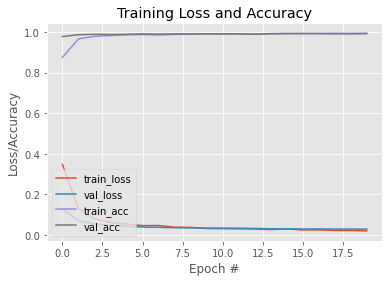

In [16]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")